# 3　logistic回帰モデル
このノートでは、分類問題における最も基本的なモデルとして知られるロジスティック回帰モデルに焦点を当てましょう。

ロジスティック回帰モデルについて、入力空間上にて出力が線形な境界(入力変数の1次式=0が決める境界)でおおよそ分離できる場合に有効なモデルで、**交差エントロピー損失**と呼ばれる損失を最小化するような1次式を予測器として学習することを説明します。また、ロジスティック回帰モデルの学習もまた
* 外れ値の影響を強く受ける。
* 多重共線性に注意する必要がある。

という注意点を説明し、**正則化**という手法を考えることが出来ることを紹介します。

In [1]:
# 以下で必要なモジュールをimportしておきましょう。
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import StandardScaler

## A　ロジスティック回帰モデルが登場するデータの様子
今度は分類問題の線形モデルの代表例であるロジスティック回帰モデル(logistic regression)を紹介しましょう。ロジスティック回帰モデルは、入力空間上にて出力が線形な境界(入力変数の1次式=0が決める境界)でおおよそ分離できる場合に有効なモデルです。

In [2]:
# デモデータの生成

#2変量正規分布
X_train = np.random.multivariate_normal(mean = [1, 1] , 
                                        cov = [[1, -0.4], [-0.4, 1]], 
                                        size = 100)

#確率pがXの1次式で定まるベルヌーイ分布B(1,p);「指数の中の一次式＝0」、つまり「p = 1/2」を境目にyの値が分離される。
y_train = np.random.binomial(n = 1, 
                             p = 1/(1+np.exp(-2.0*X_train[:, 0]-2.0*X_train[:, 1]+4.0)))

In [3]:
1/(1+np.exp(-2.0*X_train[1][0]-2.0*X_train[1][1]+4.0))

0.570202800334428

In [4]:
X_train[1]

array([0.82530977, 1.31602954])

In [5]:
y_train[1]

1

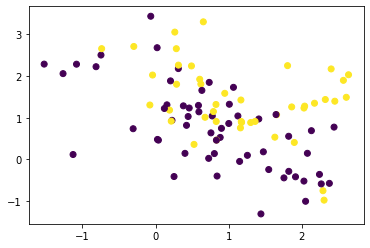

In [6]:
# データの可視化, 紫がy=0, 黄色がy=1
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train)
plt.show()

## B　仮説・損失関数
* 仮説（上の標本をみてこうかもしれないと仮説を立てる）：
    * 出力ラベル$y=1$の確率の推定モデル：
    $$\begin{align*}
    p(x;w)&=\sigma(w_0+w_1x_1+\cdots+w_dx_d)\\
    &=\frac{1}{1+\exp(-(w_0+w_1x_1+\cdots+w_d x_d))}\\
    &\text{ $\sigma(z)$はsigmoid関数とする。}\end{align*}$$
    * 確率の推定値が0.5より大きければ$y=1$, 小さければ$y=0$と予測する。
* 損失関数：交差エントロピー損失
\begin{eqnarray*}
L(w)=\begin{cases}
-\log(p(x;w))\text{ if }y = 1\\
-\log(1-p(x;w))\text{ if }y=0
\end{cases}
\end{eqnarray*}

学習時には、各データポイントに対して交差エントロピー損失を計算し、その平均値が最も小さくなるような**1次式**を予測器として求めます。見た目は難しく感じますが、丁寧に紐解いていけば、実はさほど難しくありません。以下の演習を通して、仮説と損失関数の意味を理解しましょう。

**演習** この演習ではsigmoid関数とは何かを説明しましょう。sigmoid関数とは
$$\sigma(z)=\frac{1}{1+\exp(-z)}$$ $$\exp(-z) = e^{-z}$$
のことです。これについて以下の問いに答えてください。
1. sigmoid関数のグラフを$-3<z<3$の範囲で描いてみてください。
2. 取りうる値の範囲が0から1までであること、特に$\sigma(0)=0.5$を確認してください。
3. 入力$x$に対して、出力ラベル$y=1$の確率$p$の予測式として$p = \sigma(w_0+w_1x)$を考えましょう。$w_1$が正の値のとき、入力$x$が大きくなるほど出力ラベル$y$は0または1のどちらと推定するのが妥当か検討してください。

**演習問題のための参考資料**

In [7]:
# sigmoid関数を実装する。
def sigmoid(z):    # sigmoid関数の実装
    return 1/(1 + np.exp(-z))

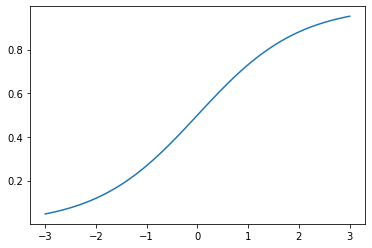

In [8]:
# sigmoid関数のグラフ

#描画したい範囲の入力たちのnp.arrayを作る
z = np.linspace(start = -3.0, stop = 3.0, num = 100)
y = sigmoid(z)
plt.plot(z, sigmoid(z))
plt.show()

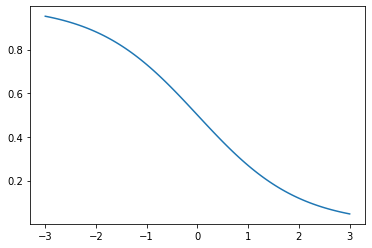

In [9]:
# sigmoid関数のグラフ

#描画したい範囲の入力たちのnp.arrayを作る
z = np.linspace(start = -3.0, stop = 3.0, num = 100)
y = sigmoid(z)
plt.plot(z, 1/(1 + np.exp(z)))
plt.show()

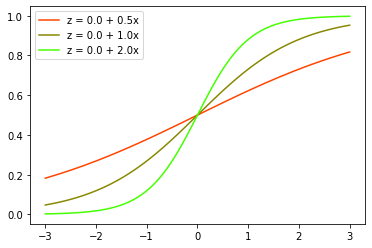

In [10]:
# 確率の予測式σ（w0+w1*x）のグラフの比較、特にxの係数w1を変化させた時のグラフの変化。
x = np.linspace(start = -3.0, stop = 3.0, num = 100)
y1 = sigmoid(0.0+0.5*x)
y2 = sigmoid(0.0+1.0*x)
y3 = sigmoid(0.0+2.0*x)
plt.plot(x, y1, c = "#FF4400",  label = "z = 0.0 + 0.5x")
plt.plot(x, y2, c = "#888800",  label = "z = 0.0 + 1.0x")
plt.plot(x, y3, c = "#44FF00", label = "z = 0.0 + 2.0x")
plt.legend()
plt.show()

**演習**　ここでは交差エントロピー損失とはなにかを調べましょう。次の問いに答えてください。
1. $L = -\log(p)$のグラフを$0<p<1$の範囲で描いてください。
2. 交差エントロピー損失によって、出力ラベルとモデルによる確率の予測の結果が食い違った場合に、実際大きな損失が与えられることを確認してください。（$L(w)$の値が１以上になることを確認）
3. 交差エントロピー損失は資料によって
$$L(w)=-\left\{y\log(p(x;w))+(1-y)\log(1-p(x;w))\right\} = -y \log(p(x;w)) +(y-1) \log(1-p(x;w))$$
と説明されることがありますが、実はこの資料で紹介したものと等しい式であることを等式変形で確認してください。

$y=1$のとき： $L(w) = -\log{p(x;w)} = -y\log{p(x;w)} +(1-y)\{-\log{(1-p(x;w))}\}$

$y=0$のとき： $L(w) = -\log(1-p(x;w)) = -y \log(p(x;w)) + (1-y)\{-\log(1-p(x;w))\}$

よって、

$$L(w) = -y\log(p(x;w))+(y-1)\log(1-p(x;w))$$

**演習問題のための参考資料**

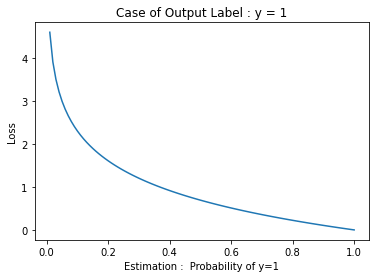

In [11]:
p = np.linspace(start = 0.01, stop = 1.00, num = 100)
L = -np.log(p)
plt.plot(p, L)
plt.xlabel("Estimation :  Probability of y=1")
plt.ylabel("Loss")
plt.title("Case of Output Label : y = 1")
plt.show()

<ipython-input-12-503b7f26e1c6>:2: RuntimeWarning: divide by zero encountered in log
  L = -np.log(1-p)


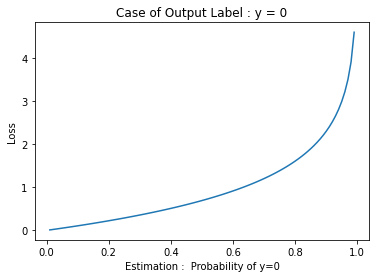

In [12]:
p = np.linspace(start = 0.01, stop = 1.00, num = 100)
L = -np.log(1-p)
plt.plot(p, L)
plt.xlabel("Estimation :  Probability of y=0")
plt.ylabel("Loss")
plt.title("Case of Output Label : y = 0")
plt.show()

**演習** 入力空間の上で予測ラベルが変化する境界線を**決定境界**と言います。ロジスティック回帰の決定境界が線形であることを説明してください。<br>

**解答**１次式＝０が確率$p=1/2$に対応するから。（「線形である」＝「1次式＝０で定まる」）

## C　逆正則化ハイパーパラメータ
ロジスティック回帰モデルでも、線形回帰モデルと全く同様にして正則化項による罰則を加えることがあります。要は学習時に、目的関数
$$J(w) = \frac{1}{n}\sum_{i=1}^{n} -\{y_i \log(p(x_i;w))+(1-y_i)\log(1-p(x_i;w))\}+\frac{\alpha}{2}||w||_2^2$$
が最も小さくなるような1次式を予測器として求める。ここで$\alpha$は正則化項を損失に比べてどれだけ重要視するか調整するハイパーパラメータで、学習時には適切な値を自分で決める必要があります。

なお、罰則は$||w||_1=|w_0|+|w_1|+\cdots+|w_d|$でも勿論よく、$||w||_w^2$による正則化を$L^2$正則化、$||w||_1$による正則化を$L^1$正則化といいます。

また`sklearn`モジュールでは、ロジスティック回帰を行う際に正則化項を用いないという設定が（厳密には）できないようになっていて、**逆正則化ハイパーパラメータ**`C`（$\alpha=1/(nC)$）を0より大きい値で代入することになっています。（なぜ正則化ハイパーパラメータでなく、わざわざ逆正則化ハイパーパラメータが実装されているのかは、SVMを解説するなかでわかってくると思います。）

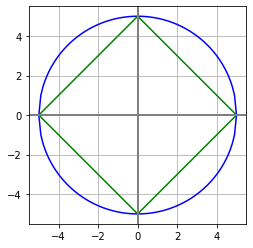

In [13]:
#罰則（L1ノルムやL2ノルム）の値
r = 5

#L2ノルムrの点(x,y)のx座標
x1 = np.linspace(start = -r, stop = r, num = 100)

#L2ノルムがrのwたち＝半径rの円
plt.plot(x1,np.sqrt(r**2-x1**2), c = "blue")
plt.plot(x1,-np.sqrt(r**2-x1**2), c = "blue")

#L1ノルムrの点(x,y)のx座標
x2plus = np.linspace(start = 0, stop = r, num = 100)
x2minus = np.linspace(start = -r, stop = 0, num = 100)

#L1ノルムがrのwたち=一辺rのひし形
plt.plot(x2plus,r-x2plus, c = "green")
plt.plot(x2plus,-r+x2plus,c = "green")
plt.plot(x2minus,r+x2minus, c = "green")
plt.plot(x2minus,-r-x2minus,c = "green")

plt.plot(0,0,c = "black")

#これ入れると描画領域が正方形に
plt.axis('square')

#グリッドの表示
plt.grid()

# 横軸(horizon)ゼロの太線化
plt.axhline(0, linewidth=2, color="gray")

# 縦軸(Vertical)ゼロの太線化
plt.axvline(0, linewidth=2, color="gray")

plt.show()

## D　LogisticRegressionのsklearnによる実装
### 前処理
これから`sklearn`モジュールでlogistic回帰を行うにあたって、正則化ハイパーパラメータを用いるため、入力変数を標準化しておきましょう。標準化を行うには、`sklearn.preprocessing`モジュールの`StandardScaler`クラスを使います。

In [14]:
# 入力を標準化する。
SS = StandardScaler()
X_train_ss = SS.fit_transform(X_train)

#### 学習と予測
実際に入力$X$と出力$y$のデータからlogsitic回帰モデルを学習させてみましょう。logisitc回帰モデルは`LogisticRegression`というクラス名で`sklearn.linear_model`モジュールに含まれています。logistic回帰の逆正則化ハイパーパラメータは`C`という引数で指定できます。（ただし$C = n\lambda$です。）また、正則化は`penalty`引数で`l1`と`l2`を選択できます。
* fitメソッド：学習
* predict_probaメソッド：確率の推定値を計算する。
* predictメソッド：予測ラベルを計算する。

In [15]:
LR = LogisticRegression(C = 100.0, penalty = "l2")    # インスタンスを建てる。
LR.fit(X_train_ss, y_train)    # fitメソッド：学習させる。

LogisticRegression(C=100.0)

In [16]:
# テストデータの入力を生成し、実際に予測させる。
# 格子点上にデータを生成する。
xx, yy = np.meshgrid(
    np.linspace(start = -2.0, stop = 4.0, num = 100), 
    np.linspace(start = -2.0, stop = 4.0, num = 100))
X_test = np.c_[xx.ravel(), yy.ravel()]
# 入力の標準化
X_test_ss = SS.transform(X_test)    # 訓練時の標準化と同じ式を用いる。
# 確率の推定
y_prob = LR.predict_proba(X_test_ss)    # predict_probaメソッド：y=1の確率の推定値
y_prob

array([[9.99732656e-01, 2.67343833e-04],
       [9.99711558e-01, 2.88441739e-04],
       [9.99688796e-01, 3.11204105e-04],
       ...,
       [5.94098507e-04, 9.99405901e-01],
       [5.50655827e-04, 9.99449344e-01],
       [5.10388213e-04, 9.99489612e-01]])

In [17]:
xx.ravel()

array([-2.        , -1.93939394, -1.87878788, ...,  3.87878788,
        3.93939394,  4.        ])

In [18]:
yy.ravel()

array([-2., -2., -2., ...,  4.,  4.,  4.])

In [19]:
X_test

array([[-2.        , -2.        ],
       [-1.93939394, -2.        ],
       [-1.87878788, -2.        ],
       ...,
       [ 3.87878788,  4.        ],
       [ 3.93939394,  4.        ],
       [ 4.        ,  4.        ]])

In [20]:
LR.classes_

array([0, 1])

In [21]:
y_prob[9999]

array([5.10388213e-04, 9.99489612e-01])

In [22]:
X_test[9999]

array([4., 4.])

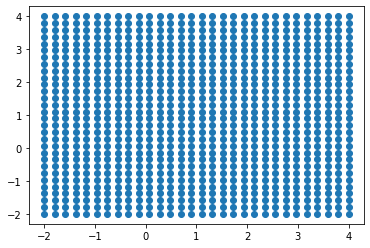

In [23]:
#xxとyyのイメージ
aa,bb = np.meshgrid(
    np.linspace(start = -2, stop =4, num = 30),
    np.linspace(start = -2, stop =4, num = 30))
plt.scatter(aa,bb)

In [24]:
y_pred = LR.predict(X_test_ss)    # predictメソッド：予測ラベルの計算
y_pred

array([0, 0, 0, ..., 1, 1, 1])

In [25]:
y_pred[9999]

1

#### 結果の確認
折角なので学習した結果を、入力をx軸に出力をy軸にとった散布図上に描いてみましょう。

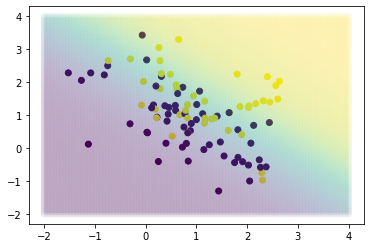

In [26]:
# データの可視化
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train)
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_prob[:, 1], alpha = 0.05)
plt.show()

また、学習によって得た予測式$f(x;w)=w_0+w_1x_1 +w_2 x_2$のパラメータ$w_0,w_1,w_2$をそれぞれ**切片**、**回帰係数**といいます。これらは次のインスタンス変数で確認できます。
* intercept_：切片 w_0
* coef_:回帰係数 w_1, w_2

In [27]:
LR.intercept_, LR.coef_

(array([-0.33366073]), array([[1.18544581, 1.36523322]]))

$f(x;w) = 0.0169 + 1.6154*X_0 + 2.0722*X_1 \Rightarrow  p(x;w) = \sigma(f(x;w))$

### E　ロジスティック回帰モデルの性質
ロジスティック回帰モデルには次のような3つの性質があります。
1. 入力と出力の関係がおおよそ1次式と言えない場合には不適切なモデルである。
2. 誤分類した外れ値の影響を強く受ける。
3. 多重共線性に注意する必要がある。

これらは、ロジスティック回帰モデルの仮説と損失の形をよく理解することで気づくことができるので、以下に説明しましょう。

#### 性質1について
これは仮説が1次式であることからきます。このような入力と出力の関係を**線形**といい、そうでない関係を**非線形**といいますが、明らかに非線形な関係がある場合にロジスティック回帰モデルは適切ではありません。
    
#### 性質2について
ロジスティック回帰モデルは誤分類した外れ値の影響を強く受けます。次のような例を考えてみましょう。
<img src="./imgs/outliner_LogisticRegression.png">

1. 決定境界が外れ値のある点に引っ張られている。
2. 全体的に色が薄くなっている。

今回、外れ値がなかった先ほどとは異なり、決定境界の傾きが緩やかになっていることがわかります。また、このときのロジスティック回帰の入力の第1変数、第2変数に対する回帰係数の値は$[0.6, 1.2]$と小さい値になり、ロジスティック回帰モデルは全てのデータポイントに$0.5$にほど近い確率の推定値を計算しています。

このように、ロジスティック回帰モデルは外れ値に引っ張られてしまいます。これはロジスティック回帰モデルは、損失が交差エントロピー損失であることから外れ値で誤分類してしまうと、そこでの損失がとても大きくなる傾向があるからです。（上の演習問題で描いた交差エントロピー損失のグラフからもみて取れます。）そのため、学習時に交差エントロピー損失を最小にする過程で、外れ値での損失をなるべく小さくするようにパラメータが求められ、外れ値に引っ張られてしまうのです。

#### 性質3について
例えば、2つの入力変数$x_1$と$x_2$がちょうど値が2倍になっているような場合を考えてみましょう。この場合、
* $p(x;w) = \sigma(x_1 + x_2)$
* $q(x;w) = \sigma(3x_1)$
* $x_2 = 2x_1$

という2つの確率の推定モデルの間で予測値は異なるでしょうか？いえ、実は同じです。すなわち、この2つの1次式はどちらも全く同じ損失を達成します。ロジスティック回帰モデルは、このようにある列が他の列によっておよそ1次式で表現できてしまうような場合、得られたデータに対する学習結果が不安定になってしまいます。これについては、線形回帰モデルと同様に**正則化**を行うことで対処するのが一つの方法です。

## F　Cの探索
実際には正則化ハイパーパラメータ`C`は探索して決めることになります。ここでは、grid searchという考え方で`C`を探索する手法を一例として紹介しておきましょう。（詳細は改めて、モデル選択のトピックで説明します。）

In [28]:
from sklearn.model_selection import GridSearchCV
params = {"C" : [0.01, 0.1, 1.0, 10.0, 100.0]}    # Cの候補を辞書型で指定する。
clf = GridSearchCV(estimator = LogisticRegression(penalty = "l2"),
                   param_grid = params,
                   scoring = "accuracy",
                   cv = KFold(n_splits = 5, shuffle = True), 
                  return_train_score = True)

clf.fit(X_train_ss, y_train)
clf.best_params_

{'C': 0.1}